In [1]:
# The idea here is to use the poet algorithm
# The poet algorithm has two pieces:
# The environments (in this case they will be sequences of symbols)
# The solvers (in this case they will be markov chains)

# A solver is marked as "solving" a given environment if it decodes it as the highest probability at each step
# I'll start with markov chains, then move to transformers once everything else is set up

# The algorithm works as follows:
# Generate the initial E and S (environments and solvers).
# Throw out any e in E and s in S that doesn't have one solver that solves it/doesn't have at least one environment it solves
# For any remaining, mutate them

# The problem with markov chains is that they can't look back very far, because they take a very brute force approach.
# We could loosen this by making nodes "relative" (k back is a). The problem with this is that nodes are doing outputs, and
# "outputting k back an a" doesn't really make sense. Actually, it does: just insert an a at that position.

# Given a sequence
# abcabc
# initially a markov chain would do
# a->b with pr 1
# b->c with pr 1
# c->a with pr 1
# or with size 2 we could say
# ab -> c
# bc -> a
# ca -> b
# ab -> c
# however we could also do
# a[-1] -> b
# a[-2] -> c
# b[-1] -> c
# b[-2] -> c
# ehh, really what we want is a grammar structure:
# x -> abc
# start -> xx
# the other way to think about it is asking if there is some "background, true state" that is unseen and probabilistically outputs things (HMM)
# okay so I like the idea of using grammars to generate strings.
# So we'll do it like this:



# Start with some random grammars
# Each grammar generates lots of strings
# Any grammar survives if it generated a string recognized by another grammar

# how to deal with "can solve everything?"
# one option - don't allow solve everything (MC is solves at least one and doesn't recognize at least one)
# or you could do more complex things: multiple populations, solves at least one from my pop and doesn't solve any from other pop
# etc.
# but ideally we want some NP-Complete thing where solving is hard

In [135]:
import random
from collections import defaultdict
from lark import Lark
from lark.exceptions import LarkError

class CFGrammar(object):
    def __init__(self, startSymbol, alphabet):
        self.startSymbol = startSymbol
        self.alphabet = alphabet
        self.rules = defaultdict(list)
        self.parser = None
        self.parent = None
        self.children = []
        
    def addRule(self, inSymbol, outSymbols):
        self.rules[inSymbol].append(outSymbols)
        # need to recreate parser
        self.parser = None
    
    def extractAlphabet(self):
        allLetters = set()
        for k, v in self.rules.items():
            for l in v:
                for x in l:
                    allLetters.add(x)
            allLetters.add(k)
        return sorted(list(allLetters))

    def generate(self, maxLen, maxIters=-1):
        curStr = [self.startSymbol]
        iter = 0
        while len(curStr) < maxLen:
            #print("".join(curStr))
            # we can only replace things that have a repacement rule to use
            validReplace = [(s, i) for (i, s) in enumerate(curStr) if s in self.rules]
            if len(validReplace) == 0: break # only have terminal symbols
            replaceIndex = random.choice(range(len(validReplace)))
            replaceSymbol, curIndex = validReplace[replaceIndex]
            replacedWith = random.choice(self.rules[replaceSymbol])
            #print(replaceSymbol, curIndex, "".join(replacedWith))
            curStr.pop(curIndex)
            # by doing last to first and inserting them there, it'll put them in the correct order
            for c in replacedWith[::-1]:
                curStr.insert(curIndex, c)
            iter += 1
            if maxIters >= 0 and iter >= maxIters: break
        return "".join(curStr)
    
    def quoteTerminals(self, arr):
        resArr = []
        for x in arr:
            if x in self.rules:
                resArr.append(x)
            else:
                resArr.append('"' + x +'"')
        return resArr
    
    def createParser(self):
        if self.parser is None:
            productionString = self.getProductionString(patchUp=True)
            self.parser = Lark(productionString)
    
    def parse(self, inputStr):
        self.createParser()
        return self.parser.parse(inputStr)

    def doesParse(self, inputStr):
        try:
            self.parse(inputStr)
            return True
        except LarkError as e:
            #print(e)
            #print(type(e))
            #raise
            return False
    
    def copy(self):
        newGrammar = CFGrammar(self.startSymbol, self.alphabet)
        for k, v in self.rules.items():
            for l in v:
                newGrammar.addRule(k, [x for x in l])
        return newGrammar

    def makeChild(self):
        outputGrammar = self.copy()
        if random.random() < 0.5:
            outputGrammar.mutateAddNewRule()
        else:
            outputGrammar.mutateRemoveRule()
        outputGrammar.parent = self
        self.children.append(outputGrammar)
        return outputGrammar
        
    def mutateAddNewRule(self):
        inputVal = random.choice(self.alphabet)
        outputLen = random.choice([1,2,3])
        outputRule = [random.choice(self.alphabet) for _ in range(outputLen)]
        self.addRule(inputVal, outputRule) # might be duplicate, that's okay it upweights it when generating
        return (inputVal, outputRule)
    
    def __len__(self):
        keys = [k for k in self.rules.keys() if k != self.startSymbol] 
        lengths = [len(self.rules[k]) for k in keys]
        return sum(lengths)
    
    def mutateRemoveRule(self):
        # since we don't add any start -> ___ in mutateAddNewRule,
        # don't remove start -> symbol rule or we'd get stranded
        keys = [k for k in self.rules.keys() if k != self.startSymbol] 
        lengths = [len(self.rules[k]) for k in keys]
        numRules = sum(lengths)
        # we don't want to make empty grammars
        if numRules <= 1:
            #print("Failed to remove because only one rule")
            return
        # do a weighted choice, where weight = number of rules
        # this ensures we uniformly choose a rule, since tokens with more rules will be chosen more often
        ruleRemove = random.choices(population=keys, weights=lengths, k=1)[0]
        # once we've chosen the key, randomly choose one of its rules to remove
        indexRemove = random.choice(range(len(self.rules[ruleRemove])))
        # actually remove the rule
        self.rules[ruleRemove].pop(indexRemove)
        if len(self.rules[ruleRemove]) == 0:
            del self.rules[ruleRemove]
            
    def getProductionString(self, patchUp=False):
        productionString = []
        if patchUp:
            terminals = set(self.alphabet) - set(self.rules.keys())
            for terminal in terminals:
                productionString.append(terminal + ": " + '"' + terminal + '"')
        for k, v in self.rules.items():
            curList = []
            for outputList in v:
                if patchUp:
                    curList.append(" ".join(self.quoteTerminals(outputList))) # all terminals need to be quoted or lark gets angry
                else:
                    curList.append(" ".join(outputList))
            if patchUp and k != self.startSymbol:
                curList.append('"' + k + '"') # because our generation terminates early, all symbols need "terminal" versions of them
            productionString.append(k + ": " + " | ".join(curList))
        productionString = "\n".join(productionString)
        return productionString

    def __repr__(self):
        return self.getProductionString()

In [136]:

def mcEvolution(popSize, numIters, generateLen, generateMaxIters, alphabet):
    def newPopMember():
        x = CFGrammar("start", alphabet) # alphabet also contains start token so we can use it
        inputVal, outputRule = x.mutateAddNewRule()
        inputVal, outputRule = x.mutateAddNewRule()
        inputVal, outputRule = x.mutateAddNewRule()
        inputVal, outputRule = x.mutateAddNewRule()
        # make sure our new rule can be used, helps prevent degenerate things
        if inputVal != 'start':
            x.addRule("start", inputVal)
        return x

    pop = [newPopMember() for _ in range(popSize)]
    originalPop = pop
    for x in pop:
        print(x)
        print("\n")
        
    for t in range(numIters):
        print("iter:", t)
        generatedStrs = [[x.generate(generateLen, generateMaxIters) for _ in range(generateLen)] for x in pop]
        nextGens = []
        likedCounts = defaultdict(int)
        dislikedCounts = defaultdict(int)
        for i, x in enumerate(pop):
            satisfiedMC = False
            satisfiedMC2 = False
            for j, strs in enumerate(generatedStrs):
                # we can obviously parse our own stuff
                if j == i: continue
                for s in strs:
                    '''
                    print("\nInThing:\n")
                    print(x.getProductionString(True))
                    print("\nGenThing:\n")
                    print(pop[j].getProductionString(True))
                    print("\nParseStr:\n")
                    print(s)
                    display(SVG(tree.pydot__tree_to_graph(pop[j].parse(s)).create_svg() ))
                    print("trying")
                    '''
                    if x.doesParse(s):
                        likedCounts[s] += 1
                        '''
                        print("\nInThing:\n")
                        print(x.getProductionString(True))
                        print("\nGenThing:\n")
                        print(pop[j].getProductionString(True))
                        print("\nParseStr:\n")
                        print(s)
                        print("\ParseTreeGen:\n")
                        display(SVG(tree.pydot__tree_to_graph(pop[j].parse(s)).create_svg() ))
                        print("\nParseTreeIn:\n")
                        display(SVG(tree.pydot__tree_to_graph(pop[i].parse(s)).create_svg() ))
                        '''
                        satisfiedMC = True
                    else:
                        dislikedCounts[s] += 1
                        satisfiedMC2 = True
                    #if satisfiedMC and satisfiedMC2: break
                #if satisfiedMC and satisfiedMC2: break
            if satisfiedMC and satisfiedMC2:
                nextGens.append(x)
        likePercent = [(s, c/(c+dislikedCounts[s])) for (s,c) in likedCounts.items()]
        likePercent.sort(key=lambda x: -x[1])
        for s, c in likePercent[:10]:
            print(s, c)
        print(len(nextGens), "survived")
        #for x in nextGens:
        #    print(x)
        #    print("\n")
        newPop = []
        if len(nextGens) == 0:
            print("rip")
            break
        while len(newPop) < popSize:
            newPop.append(random.choice(nextGens).makeChild())
        pop = newPop
        ayy = [x for x in pop]
        ayy.sort(key=lambda x: -len(x))
        print("top spookers")
        for x in ayy[:2]:
            print(len(x))
            print(x)
        print(sum([len(x) for x in pop])/float(len(pop)))
        pop = ayy
    return originalPop, pop
random.seed(27)
orig, final = mcEvolution(popSize=20, numIters=100, generateLen=20, generateMaxIters=10, alphabet=['a', 'b', 'c', 'd', 'e', 'f', 'g'])
                

f: f c
c: a | c g
a: g e
start: c


g: b b
b: g a
f: e f a
e: g d
start: e


f: f
d: a g
g: d c b
e: e f
start: e


b: g e b
a: g c
f: g | a b d
start: f


f: c | d
e: b
g: c
start: g


e: d a c
d: c a
c: g | d
start: c


c: a e b | g a
b: g
f: e a
start: c


d: f a | e a
c: g e
f: a c d
start: d


e: c | c
b: e e
f: a
start: e


g: c
f: g a a
e: d f
d: a b g
start: d


c: a e b
b: b g
f: g d
g: c
start: g


a: a
g: c
b: d
e: a b
start: e


e: g c | b g
a: d b c
d: f b
start: d


e: f
f: e f
a: a
d: e e f
start: d


a: d | a c
c: a b
b: g
start: b


e: f a b | g g d | b
d: e
start: e


c: b a e | e b d
e: g d c
f: b
start: f


a: b e
b: c d d
c: b
e: e
start: e


g: g a f | b a g
e: e a
d: f
start: d


f: c | g d f
c: e e d
g: e a
start: g


iter: 0
c 0.2631578947368421
e 0.2631578947368421
g 0.2631578947368421
f 0.10526315789473684
b 0.10526315789473684
ga 0.05263157894736842
ea 0.05263157894736842
effff 0.05263157894736842
efff 0.05263157894736842
eff 0.05263157894736842
16 survived


g 0.5263157894736842
e 0.42105263157894735
fa 0.2631578947368421
defccegc 0.10526315789473684
fbdededbgcc 0.10526315789473684
gg 0.10526315789473684
gggg 0.10526315789473684
ggg 0.10526315789473684
deddededbcbcc 0.10526315789473684
ffbcdefbcbc 0.10526315789473684
20 survived
top spookers
12
d: f b c | g c
c: g | d
start: c
f: d e d | e e
a: e b | g f
b: d f | e | e
g: c e
12
d: f b c
c: g | d | g
start: c
f: d e d | e e
a: e b | g f | d
b: c
e: d e | d b
7.2
iter: 18
g 0.5789473684210527
e 0.3157894736842105
dedbcefbcbdedbc 0.2631578947368421
fbcefbggg 0.21052631578947367
ffbcfcd 0.21052631578947367
fbcefbcdfbc 0.21052631578947367
dfbcbdedcccc 0.21052631578947367
dfbcefcccd 0.21052631578947367
fbcdbdcfcc 0.21052631578947367
fbfbcdefbccc 0.21052631578947367
20 survived
top spookers
11
f: f | g d g
g: b e g
start: e
c: c f | b
b: d a g | f d e
e: f a | b
a: e | b c a
11
d: f b c
c: g | d | g
start: c
f: d e d | e e
a: e b | g f | d
b: c
e: d b
6.5
iter: 19
g 0.5789473684210527
e 0.368421

e 1.0
eadadadadadadadadad 0.10526315789473684
d 0.05263157894736842
f 0.05263157894736842
aff 0.05263157894736842
fff 0.05263157894736842
ffa 0.05263157894736842
20 survived
top spookers
18
f: g d g | f c c | d b | f | e c | b | d e
g: b e g
start: e
c: c f | b | c b | a e
b: d a g | f d e
a: e | b a
d: f | f
18
f: g d g | f c c | d b | f | e c | b
g: b e g | f f
start: e
c: c f | b | c b | a e
b: d a g | f d e
a: e | b a
d: f | f
10.8
iter: 36
e 1.0
eadadadadadadadadad 0.15789473684210525
fff 0.05263157894736842
f 0.05263157894736842
d 0.05263157894736842
faf 0.05263157894736842
ffa 0.05263157894736842
faa 0.05263157894736842
20 survived
top spookers
17
f: g d g | f c c | d b | f | e c | b
g: b e g | f f
start: e
c: c f | b | c b | a e
b: d a g | f d e
a: e | b a
d: f
17
f: f c c | d b | f | e c | g
g: b e g | e a g
start: e
c: c f | b | c b
b: d a g | f d e | c c
a: e | b a | f b b
d: f
9.6
iter: 37
e 1.0
eadadadadadadadadad 0.15789473684210525
20 survived
top spookers
18
f: g d g | 

e 1.0
fcfbebfbecbfbe 0.10526315789473684
eccecbefcefbe 0.10526315789473684
dbcfbedbcfbee 0.10526315789473684
fcfbefbfcfbefbe 0.10526315789473684
fcfbefbfbe 0.10526315789473684
fbecbfbfbfbfcee 0.10526315789473684
dcecefcefcfbee 0.10526315789473684
dbcfbfbefcfbefbe 0.10526315789473684
fcebecbfcefbe 0.10526315789473684
20 survived
top spookers
12
f: d b | f | e c | g d b | a b g
start: e
c: c b
b: d a g | c e
d: f | f
a: g
g: b c
12
f: d b | f | g f | b f b
start: e
b: f d e | c e
g: g | e
e: c f | d c
c: f d b | c b
6.4
iter: 54
e 1.0
dcfdcbcbefdcfdedb 0.10526315789473684
dfddcfdefde 0.10526315789473684
dfdcbcfddbdcfdeb 0.10526315789473684
dcfddcfdebfddcbb 0.10526315789473684
dcbcbcfdcbecbcfdeb 0.10526315789473684
eccfcecbefbefbe 0.10526315789473684
fbfbfcfbeeccfbee 0.10526315789473684
dbcfbeeccfbfbee 0.10526315789473684
fcecceefbeccee 0.10526315789473684
20 survived
top spookers
13
f: d b | f | e c | g d b | a b g
start: e
c: c b
b: d a g | c e
d: f | f | e
a: g
g: b c
13
f: d b | f | g

e 1.0
cggf 0.5263157894736842
fafadbdbbf 0.5263157894736842
dbafadbacf 0.5263157894736842
dbdbbdb 0.5263157894736842
dbafafafae 0.5263157894736842
fdbbfaeb 0.47368421052631576
ffabfbgf 0.47368421052631576
bgf 0.47368421052631576
efdbdb 0.47368421052631576
20 survived
top spookers
14
f: f | g f | c
start: e
g: g
e: c f | f a e
c: f d b | c b | b | e | d
d: e | f a a
a: f
14
f: d b | f | g f
start: e
g: g
e: c f | f a e
c: f d b | c b | b | e
d: e | f a a
a: f | d
9.8
iter: 70
e 1.0
dbebfafacf 0.42105263157894735
gfdbgf 0.3684210526315789
cbgeb 0.3684210526315789
dbgffdbcf 0.3684210526315789
bgf 0.3684210526315789
cffabffb 0.3684210526315789
ggfgffffae 0.3684210526315789
bgdbacgfb 0.3684210526315789
bgfebdbb 0.3684210526315789
20 survived
top spookers
15
f: d b | g f | b d e
start: e
b: c e
g: g
e: c f | f a e | d | c f e
c: f d b | c b | b | e d a
d: e
a: a a d
15
f: d b | g f
start: e
b: c e
g: g
e: c f | f a e | d | c f e
c: f d b | c b | b | e d a
d: e | f c
a: a a d
8.6
iter: 71
e 1

d 0.5263157894736842
fdbf 0.5263157894736842
fdbbf 0.47368421052631576
fdbbbbbbbf 0.47368421052631576
ffdbfbf 0.3157894736842105
ggfgfggfdbbf 0.3157894736842105
febf 0.3157894736842105
gfdbbbggf 0.2631578947368421
ggggfdbbbgf 0.2631578947368421
gfgffdbbgggf 0.2631578947368421
20 survived
top spookers
20
f: f | g | b a | c
start: e
g: g | b b
e: f a e
c: c b | b | e | c b | g
d: e | f a a | f | e b b
a: f | b f
b: c b e | f d g
18
f: f | g | b a
start: e
g: g | b b
e: f a e
c: c b | b | e | c b
d: f a a | f
a: f | b f
b: c b e | f d g | a b d | b a
13.0
iter: 86
d 0.5789473684210527
gfggfcbgggf 0.3157894736842105
fdbgggf 0.3157894736842105
ggfdbgggggf 0.3157894736842105
ggfebggf 0.3157894736842105
fgfcbgggf 0.3157894736842105
gggae 0.2631578947368421
ggfae 0.2631578947368421
dgedcd 0.2631578947368421
fcgggfbbgf 0.2631578947368421
19 survived
top spookers
19
f: f | g | b a | c
start: e
g: g | b b
e: f a e
c: c b | b | c b | g
d: e | f a a | f | e b b
a: f | b f
b: c b e | f d g
17
f: d b

In [173]:
def getProductionString(self, patchUp=False):
    productionString = []
    if patchUp:
        terminals = set(self.alphabet) - set(self.rules.keys())
        for terminal in terminals:
            productionString.append(terminal + ": " + '"' + terminal + '"')
    for k, v in sorted(list(self.rules.items())):
        curList = []
        if not patchUp:
            if k == self.startSymbol: continue
        
        h = [tuple(l) for l in v]
        h.sort()
        for outputList in h:
            if patchUp:
                curList.append(" ".join(self.quoteTerminals(outputList))) # all terminals need to be quoted or lark gets angry
            else:
                curList.append(" ".join(outputList))
        if patchUp and k != self.startSymbol:
            curList.append('"' + k + '"') # because our generation terminates early, all symbols need "terminal" versions of them
        productionString.append(k + ": " + " | ".join(curList))
    productionString = "\n".join(productionString)
    return productionString

def traverse(p, callback, *args, **kwargs):
    callback(p, *args, **kwargs)
    for c in p.children:
        traverse(c, callback, *args, **kwargs)

        
def process(p, arr):
    arr[str(p)] += 1

arr = defaultdict(int)
for p in orig: traverse(p, process, arr)
arr = list(arr.items())
arr.sort(key=lambda x: -x[1])
len(arr), arr

(1898,
 [('start: g\na: c g', 6),
  ('start: g\nd: f | a d\nb: b', 4),
  ('c: e e d\nstart: g', 4),
  ('f: f | g\nd: a g\ng: d c b\ne: e f\nstart: e\nb: f g e\na: b c', 3),
  ('start: e\nb: f d e | d\nd: d e\nc: e d | c g d | g', 3),
  ('start: e\nb: a\nc: g\na: f\nf: d a', 3),
  ('start: e\nb: c', 3),
  ('f: d b | g f | g\nstart: e\nb: c e\ng: g\ne: c f | f a e | c f e\nc: c b | e d a | g d\nd: e',
   3),
  ('g: b e g | a f\nstart: e\nb: d a g | f d e\ne: f a\nc: b f e', 3),
  ('start: e\nc: f | c f\na: d e', 3),
  ('start: e\nc: c f\na: d e', 3),
  ('start: e\nc: e f c', 3),
  ('a: a\nstart: e', 3),
  ('f: c | g d f\nc: e e d\nstart: g', 3),
  ('f: c | g d f\nc: e e d\nstart: g\na: d b f', 3),
  ('start: g\nf: b\nc: d e g', 3),
  ('f: c | g d f | g g c\nstart: g\ng: d c', 3),
  ('b: g a\nf: e f a\nstart: e', 2),
  ('f: g\nd: a g\ng: d c b\ne: e f\nstart: e\nb: f g e | a\na: b c\nc: d f',
   2),
  ('f: f | g d g\ng: b e g\nstart: e\nc: c f | b\nb: d a g | f d e\ne: f a\na: e | b c a |

In [174]:
import graphviz
def familyTreeToDot(pop):
    dot = graphviz.Digraph()
    
    def pretty(p):
        return p.replace("|", "l").replace(":", "i").replace("\n", "   ")
    
    def processDot(p, dot):
        if not p.parent is None:
            dot.edge(pretty(getProductionString(p.parent)), pretty(getProductionString(p)))
    
    for p in orig: traverse(p, processDot, dot)
        
    return dot

dot = familyTreeToDot(orig)

In [175]:
dot.render('totes.svg')

'totes.svg.pdf'

In [101]:
g = CFGrammar("start", [])
g.addRule("start", ["a"])
g.addRule("a", ["a", "b"])
g.parse("abbbbbba")


UnexpectedCharacters: No terminal defined for 'a' at line 1 col 8

abbbbbba
       ^
Expected one of: 
	* B


parsing: ((x-(m*(x/n)))/(x/x))
start: x | "start"
x: start | m | d | n | "x"
p: "(" x "+" x ")" | "p"
n: "(" x "-" x ")" | "n"
m: "(" x "*" x ")" | "m"
d: "(" x "/" x ")" | "d"


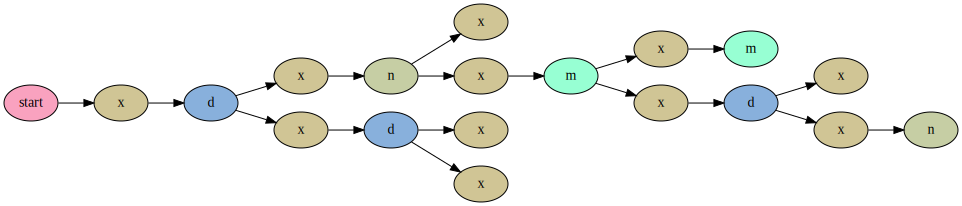

start: x
x: start | m | d | n
p: ( x + x )
n: ( x - x )
m: ( x * x )
d: ( x / x )
['(', ')', '*', '+', '-', '/', 'd', 'm', 'n', 'p', 'start', 'x']


start: x
x: start | m | n
p: ( x + x )
n: ( x - x )
m: ( x * x )
d: ( x / x )

In [25]:
# example
g = CFGrammar("start", []) # not doing any mutations so we don't need to give it an alphabet
g.addRule("start", "x")
g.addRule("x", ["start"])
g.addRule("x", ["m"])
g.addRule("x", ["d"])
g.addRule("x", ["n"])
g.addRule("p", ["(", "x", "+", "x", ")"])
g.addRule("n", ["(", "x", "-", "x", ")"])
g.addRule("m", ["(", "x", "*", "x", ")"])
g.addRule("d", ["(", "x", "/", "x", ")"])
h = "".join(g.generate(20))
print("parsing:", h)
from lark import tree
from io import StringIO
outFile = StringIO()
from IPython.display import SVG, display
display(SVG(tree.pydot__tree_to_graph(g.parse(h)).create_svg() ))
g.alphabet = g.extractAlphabet()
print(g)
print(g.alphabet)
g.makeChild()